# Stock Market Time Series Forecasting & Market Intelligence
## NIFTY 50 Index & Multi-Stock Analytics

This notebook provides an end-to-end financial analytics pipeline including:
- Multi-stock selection
- Technical indicators
- Multi-horizon forecasting (7/30/90 days)
- Volatility modeling using GARCH
- Market regime detection (Bull/Bear)
- Streamlit dashboard integration

## 1. Import Libraries

In [73]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from arch import arch_model

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


## 2. Multi-Stock Selector & Data Loader

In [74]:
import pandas as pd
import numpy as np

df = pd.read_csv("NIFTY50_all.csv")

df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values(['Symbol', 'Date'])

print(df.shape)
df.head()


(235192, 15)


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
1033,2012-01-02,ADANIPORTS,EQ,146.25,146.55,147.75,142.15,143.40,143.90,144.33,899183,1.300000e+13,12697.0,350195.0,0.3895
1053,2012-01-03,ADANIPORTS,EQ,148.65,148.00,152.00,144.00,145.50,146.85,146.38,370864,5.430000e+12,5672.0,121763.0,0.3283
1117,2012-01-06,ADANIPORTS,EQ,123.45,124.00,126.25,122.65,124.95,125.35,124.20,1088955,1.350000e+13,12370.0,567530.0,0.5212
1160,2012-01-08,ADANIPORTS,EQ,120.45,121.55,125.50,118.10,120.15,120.90,122.17,4518020,5.520000e+13,49733.0,1571713.0,0.3479
1201,2012-01-10,ADANIPORTS,EQ,127.50,128.10,128.50,124.55,125.35,125.50,125.63,470394,5.910000e+12,5258.0,208041.0,0.4423


In [75]:
MIN_OBS = 300   # safe minimum for ARIMA

valid_symbols = (
    df.groupby('Symbol')
      .size()
      .loc[lambda x: x >= MIN_OBS]
      .index
)

len(valid_symbols)


64

In [76]:
def arima_forecast(series, steps=30):
    model = ARIMA(
        series,
        order=(2,1,0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit()
    return fit.forecast(steps)


In [77]:
results = []

for symbol in valid_symbols:
    df_sym = df[df['Symbol'] == symbol].copy()
    df_sym = df_sym.set_index('Date')

    close = df_sym['Close']

    try:
        forecast_30 = arima_forecast(close, steps=30)

        results.append({
            "Symbol": symbol,
            "Last_Close": close.iloc[-1],
            "Forecast_30D_Mean": forecast_30.mean(),
            "Forecast_30D_Change_%": 
                (forecast_30.mean() / close.iloc[-1] - 1) * 100
        })

    except Exception as e:
        # Skip unstable stocks quietly
        continue


In [78]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Forecast_30D_Change_%", ascending=False)

results_df.head(10)


,Symbol,Last_Close,Forecast_30D_Mean,Forecast_30D_Change_%
6,BAJFINANCE,4511.00,4822.126828,6.897070
26,ICICIBANK,538.55,566.517333,5.193080
27,INDUSINDBK,844.40,887.690892,5.126823
62,ZEEL,181.10,189.496673,4.636484
44,SBIN,328.85,343.197209,4.362843
7,BHARTI,324.15,338.116336,4.308603
28,INFOSYSTCH,2881.25,2997.821020,4.045849
30,IOC,87.00,90.491579,4.013309
36,M&M,751.50,780.432962,3.850028
2,AXISBANK,635.60,659.198313,3.712762


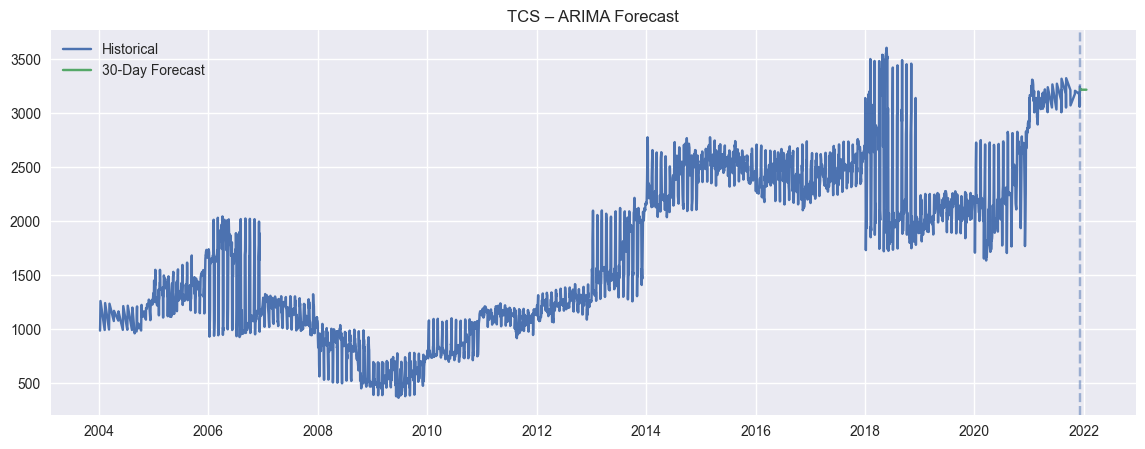

In [79]:
import matplotlib.pyplot as plt

symbol = "TCS"

df_sym = df[df['Symbol'] == symbol].set_index('Date')
forecast = arima_forecast(df_sym['Close'], 30)

future_dates = pd.date_range(
    df_sym.index[-1], periods=31, freq='B'
)[1:]

forecast = pd.Series(forecast.values, index=future_dates)

plt.figure(figsize=(14,5))
plt.plot(df_sym['Close'], label="Historical")
plt.plot(forecast, label="30-Day Forecast")
plt.axvline(df_sym.index[-1], linestyle="--", alpha=0.5)
plt.legend()
plt.title(f"{symbol} – ARIMA Forecast")
plt.show()


## 3. Exploratory Data Analysis

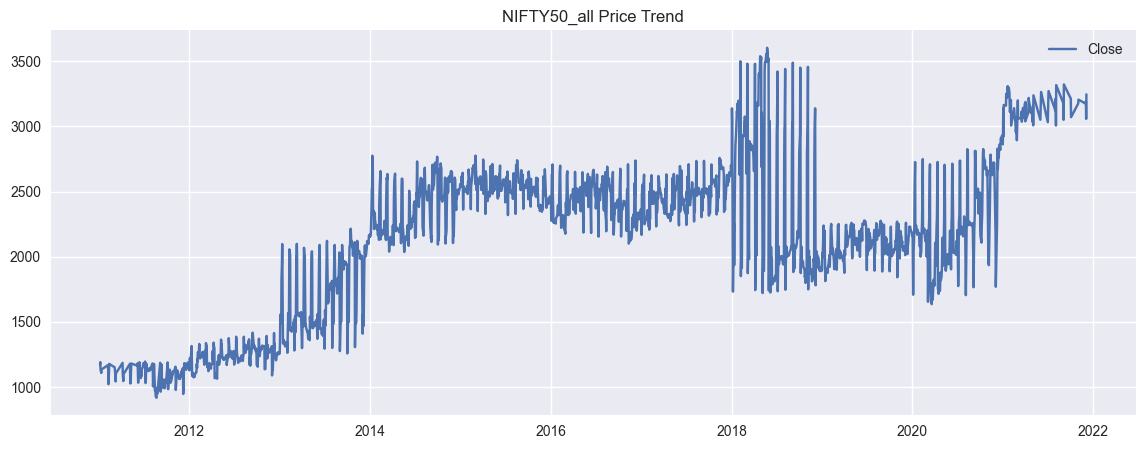

In [88]:
plt.figure(figsize=(14,5))
plt.plot(df_sym['Close'], label='Close')
plt.title(f"{SYMBOL} Price Trend")
plt.legend()
plt.show()


## 4. Technical Indicators

In [89]:
df_sym['SMA_20'] = df_sym['Close'].rolling(20).mean()
df_sym['SMA_50'] = df_sym['Close'].rolling(50).mean()
df_sym['EMA_20'] = df_sym['Close'].ewm(span=20, adjust=False).mean()

delta = df_sym['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain, index=df_sym.index).rolling(14).mean()
roll_down = pd.Series(loss, index=df_sym.index).rolling(14).mean()

RS = roll_up / roll_down
df_sym['RSI'] = 100 - (100 / (1 + RS))

df_sym.dropna(inplace=True)
df_sym.tail()


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,SMA_20,SMA_50,EMA_20,RSI
Date,,,,,,,,,,,,,,,,,,
2021-11-02,TCS,EQ,3213.30,3215.00,3219.3,3185.05,3204.50,3206.00,3201.77,1165882,3.730000e+14,53910.0,466871.0,0.4004,3151.5025,3124.372,3159.729373,53.260870
2021-12-01,TCS,EQ,3176.45,3176.45,3210.0,3150.00,3172.00,3174.85,3187.07,3611458,1.150000e+15,142696.0,1656842.0,0.4588,3158.4625,3127.963,3161.169433,47.945769
2021-12-02,TCS,EQ,3206.00,3184.20,3245.5,3182.00,3188.25,3190.80,3214.96,2777404,8.930000e+14,113414.0,872187.0,0.3140,3163.3525,3133.893,3163.991392,54.008118
2021-12-03,TCS,EQ,3070.95,3075.00,3117.0,3041.35,3053.10,3057.95,3084.20,2938317,9.060000e+14,128801.0,1465667.0,0.4988,3158.3525,3131.051,3153.892211,44.278247
2021-12-04,TCS,EQ,3322.25,3322.25,3338.1,3213.20,3250.00,3246.55,3275.21,3791828,1.240000e+15,202522.0,1329121.0,0.3505,3170.2775,3134.800,3162.716763,53.300759


## 5. Multi-Horizon Forecasting (ARIMA)

In [90]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(
    df_sym['Close'],
    order=(5,1,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit()


In [91]:
print(df.shape)
print(df.head())


(235192, 16)
           Date      Symbol Series  Prev Close    Open    High     Low  \
1033 2012-01-02  ADANIPORTS     EQ      146.25  146.55  147.75  142.15   
1053 2012-01-03  ADANIPORTS     EQ      148.65  148.00  152.00  144.00   
1117 2012-01-06  ADANIPORTS     EQ      123.45  124.00  126.25  122.65   
1160 2012-01-08  ADANIPORTS     EQ      120.45  121.55  125.50  118.10   
1201 2012-01-10  ADANIPORTS     EQ      127.50  128.10  128.50  124.55   

        Last   Close    VWAP   Volume      Turnover   Trades  \
1033  143.40  143.90  144.33   899183  1.300000e+13  12697.0   
1053  145.50  146.85  146.38   370864  5.430000e+12   5672.0   
1117  124.95  125.35  124.20  1088955  1.350000e+13  12370.0   
1160  120.15  120.90  122.17  4518020  5.520000e+13  49733.0   
1201  125.35  125.50  125.63   470394  5.910000e+12   5258.0   

      Deliverable Volume  %Deliverble  SMA_200  
1033            350195.0       0.3895      NaN  
1053            121763.0       0.3283      NaN  
1117      

In [92]:
last_date = df_sym.index[-1]

future_7  = pd.date_range(last_date, periods=8, freq='B')[1:]
future_30 = pd.date_range(last_date, periods=31, freq='B')[1:]
future_90 = pd.date_range(last_date, periods=91, freq='B')[1:]

forecast_7  = pd.Series(model_fit.forecast(7).values, index=future_7)
forecast_30 = pd.Series(model_fit.forecast(30).values, index=future_30)
forecast_90 = pd.Series(model_fit.forecast(90).values, index=future_90)


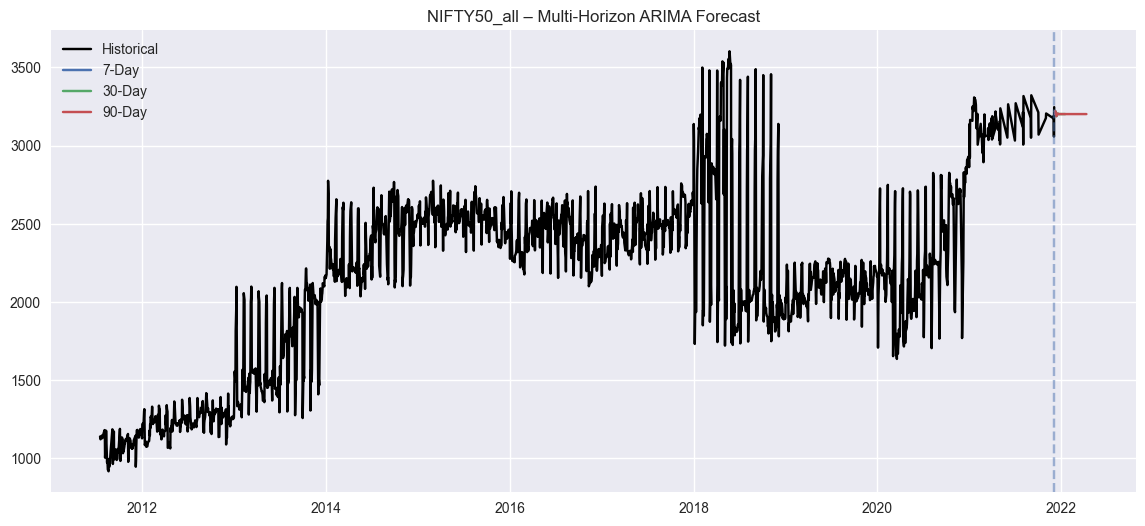

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_sym['Close'], label='Historical', color='black')
plt.plot(forecast_7, label='7-Day')
plt.plot(forecast_30, label='30-Day')
plt.plot(forecast_90, label='90-Day')

plt.axvline(last_date, linestyle='--', alpha=0.5)
plt.legend()
plt.title(f"{SYMBOL} – Multi-Horizon ARIMA Forecast")
plt.show()


## 6. Volatility Modeling with GARCH

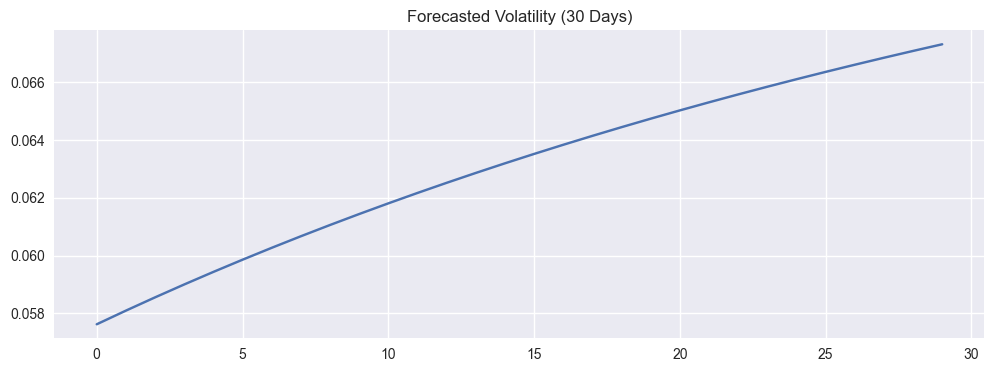

In [94]:

returns = returns = df_sym['Close'].pct_change().dropna()

garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch.fit(disp='off')

vol_forecast = garch_fit.forecast(horizon=30)
volatility = np.sqrt(vol_forecast.variance.values[-1])

plt.figure(figsize=(12,4))
plt.plot(volatility)
plt.title("Forecasted Volatility (30 Days)")
plt.show()


## 7. Market Regime Detection

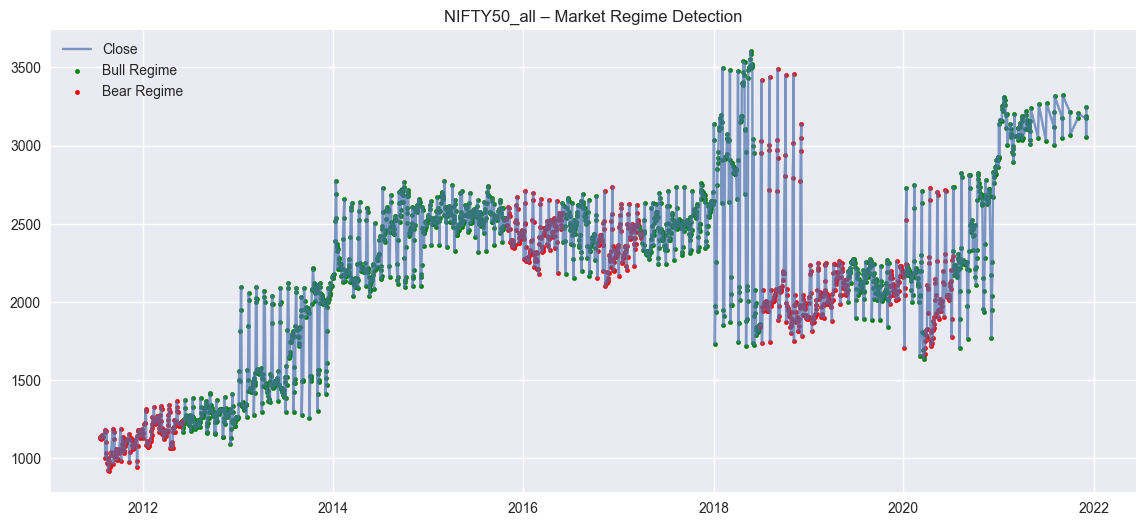

In [95]:
# 7. Market Regime Detection (per stock)

df_sym['SMA_200'] = df_sym['Close'].rolling(200).mean()

df_sym['Regime'] = np.where(
    df_sym['SMA_50'] > df_sym['SMA_200'],
    'Bull',
    'Bear'
)

plt.figure(figsize=(14,6))

plt.plot(df_sym['Close'], label='Close', alpha=0.7)

plt.scatter(
    df_sym[df_sym['Regime'] == 'Bull'].index,
    df_sym[df_sym['Regime'] == 'Bull']['Close'],
    color='green',
    s=10,
    label='Bull Regime'
)

plt.scatter(
    df_sym[df_sym['Regime'] == 'Bear'].index,
    df_sym[df_sym['Regime'] == 'Bear']['Close'],
    color='red',
    s=10,
    label='Bear Regime'
)

plt.legend()
plt.title(f"{SYMBOL} – Market Regime Detection")
plt.show()


## 8. Streamlit Dashboard Code (Save as app.py)

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np

st.set_page_config(layout="wide")
st.title("Market Forecasting Dashboard")

# ----------
# Load data ONCE
# ----------
@st.cache_data
def load_data():
    df = pd.read_csv("NIFTY50_all.csv")
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values(['Symbol', 'Date'])
    return df

df = load_data()

# ----------
# Symbol selector
# ----------
symbols = sorted(df['Symbol'].unique())
symbol = st.selectbox("Select Symbol", symbols)

# ----------
# Filter selected stock
# ----------
df_sym = df[df['Symbol'] == symbol].copy()
df_sym = df_sym.set_index('Date')

# ----------
# Indicators
# ----------
df_sym['SMA_50'] = df_sym['Close'].rolling(50).mean()
df_sym['SMA_200'] = df_sym['Close'].rolling(200).mean()

# ----------
# Charts
# ----------
st.subheader(f"{symbol} – Price Trend")
st.line_chart(df_sym['Close'])

st.subheader("Market Regime (Trend)")
st.line_chart(df_sym[['SMA_50', 'SMA_200']])


2026-02-10 12:17:29.048 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-10 12:17:29.052 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-10 12:17:29.482 
  command:

    streamlit run c:\Users\rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-02-10 12:17:29.482 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-10 12:17:29.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-10 12:17:29.496 No runtime found, using MemoryCacheStorageManager
2026-02-10 12:17:29.498 No runtime found, using MemoryCacheStorageManager
2026-02-10 12:17:29.498 Thread 'MainThread': missing Scr

DeltaGenerator()